# Variant C/D Module Interations – Regression models

The approach for fitting regression models to predict whether users are likely to interact with the Newcomer Task module is the same as we've used in the previous analyses. Because the outcome is binary, either a user did something or they did not, we use a logistic regression model. We add predictors iteratively until we find the most likely model. Like before, we have predictors for which variant the user had, whether they registered on desktop or mobile, and when they registered (in time since the start of the experiment).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
## libraries
library(tidyverse)
library(data.table)
library(ggplot2)

library(lme4)

library(caret)

library(interactions)
library(multcomp)
library(emmeans)

require(gridExtra)

## library(ROCR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: mvtnorm

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package

## Configuration variables

In [3]:
## Set BLAS threads to 1 so glmer doesn't use all cores
library(RhpcBLASctl)
blas_set_num_threads(1)

## parallelization
options(mc.cores = 4)

### Helper functions

In [4]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC = function(mod, val_data, col_name, plot_title, cutoff_steps = 0.1) {
  preds = predict(mod, val_data, type = "response")
  ROCR_pred = prediction(preds, val_data[[col_name]])
  ROCR_perf = performance(ROCR_pred, "tpr", "fpr")
  plot(ROCR_perf, colorize = TRUE, print.cutoffs.at = seq(0, 1, by = cutoff_steps),
       text.adj = c(-0.2, 1.7), main = plot_title)
}

## Function to output a confusion matrix
confusion_matrix = function(model_predictions, threshold, reference, levels = c("yes", "no")) {
  pred = factor(ifelse(model_predictions >= threshold, levels[1], levels[2]), levels = levels)
  truth = factor(ifelse(reference, levels[1], levels[2]), levels = levels)
  confusionMatrix(pred, truth, mode = 'prec_recall')
}


### Data import and setup

In [5]:
interaction_counts = fread('datasets/variant-test-2-interaction-counts.tsv',
                     colClasses = c(wiki_db = 'factor', user_registration = 'character'))

In this analysis, we're only interested in users in the Homepage group, with a valid variant assigned, who visited the Homepage. Here's how many of them we have:

In [6]:
length(interaction_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]$wiki)

[1] 32615

Note that the dataset does not include known test accounts, users who were in the control group (meaning they didn't have the Homepage enabled upon registration), or users who turned the Homepage on/off during the experiment. Also, as mentioned in the data gathering notebook, this is the same number of users who are in the task navigation and task click dataset.

In [8]:
## Configuration variables for this experiment.
start_ts = as.POSIXct('2020-10-28 18:40:02', tz = 'UTC')
end_ts = as.POSIXct('2020-11-25 18:40:02', tz = 'UTC')

## Convert user_registration into a timestamp
interaction_counts[, user_reg_ts := as.POSIXct(user_registration, format = '%Y%m%d%H%M%S', tz = 'UTC')]

## Calculate time since start of experiment in weeks
interaction_counts[, exp_days := 0]
interaction_counts[, exp_days := difftime(user_reg_ts, start_ts, units = "days")]
interaction_counts[, ln_exp_days := log(1 + as.numeric(exp_days))]
interaction_counts[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(interaction_counts)

## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

## Remove all control group users, users with an incorrect variant assignment,
## and users that didn't visit the Homepage.
exp_users = interaction_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]

## Split the experiment users into training, testing, and validation datasets
trainIndex <- createDataPartition(exp_users$hp_variant,
                                  p = .8, 
                                  list = FALSE, 
                                  times = 1)
exp_users_train = exp_users[trainIndex,]
exp_users_second = exp_users[-trainIndex,]

testIndex = createDataPartition(exp_users_second$hp_variant, p = .5, list = FALSE, times = 1)

exp_users_test = exp_users_second[testIndex,]
exp_users_validate = exp_users_second[-testIndex,]


# Module Interactions

We'll model this in the same way as we've done for task interactions and task clicks.

## Variant C/D as a predictor

In this first model, we predict whether the user edited based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [9]:
## 1: only variant as a predictor:
interact.model.1 = glmer(formula = did_interact ~ hp_variant + (1 | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

In [10]:
summary(interact.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28940.8  28965.3 -14467.4  28934.8    26089 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9003 -0.6882 -0.4589  1.1412  2.6778 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0441   0.21    
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.54829    0.05845  -9.381   <2e-16 ***
hp_variantD -0.98354    0.02960 -33.231   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.194

This model suggests that overall, variant D is associated with a lower probability of a user interacting with the Newcomer Task module.

Let us see if there's variation by wiki on this.

In [11]:
## 1: variant as a group-level predictor
interact.model.1.2 = glmer(formula = did_interact ~ hp_variant + (1 + hp_variant | wiki_db),
                           family = binomial(link = "logit"), data = exp_users_train)

In [12]:
summary(interact.model.1.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant + (1 + hp_variant | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28938.4  28979.2 -14464.2  28928.4    26087 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9145 -0.6956 -0.4707  1.0997  2.6069 

Random effects:
 Groups  Name        Variance Std.Dev. Corr 
 wiki_db (Intercept) 0.05587  0.2364        
         hp_variantD 0.01481  0.1217   -0.63
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.53251    0.06550   -8.13 4.29e-16 ***
hp_variantD -1.01632    0.04971  -20.44  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.546

In [13]:
ranef(interact.model.1.2)

$wiki_db
        (Intercept)  hp_variantD
arwiki -0.137336564  0.159334528
cswiki  0.180625333 -0.089176254
fawiki -0.091012596  0.147631710
frwiki -0.193306699 -0.019672590
hewiki  0.200270433 -0.087186027
huwiki -0.006418536 -0.017385248
hywiki  0.052727201  0.019563987
kowiki -0.473508617  0.106049244
plwiki  0.129064846 -0.087531344
ptwiki -0.272271722  0.101903331
ruwiki  0.109521128 -0.008002654
srwiki  0.053484061 -0.039106061
svwiki -0.073052728 -0.020102239
trwiki  0.353863604 -0.050021407
ukwiki -0.155950637  0.013620897
viwiki  0.342462491 -0.128637953

with conditional variances for “wiki_db” 

The model is not singular, which suggests that there's enough variation and data to support it. However, the BIC is much worse than the first model. So while there *is* some variation between wikis, it's not clear that it's large enough to be meaningful.

## Desktop/mobile registration

We add whether the user registered on desktop or mobile as a predictor.

In [14]:
## 2: add desktop/mobile
interact.model.2 = glmer(formula = did_interact ~ hp_variant + reg_on_mobile + (1 | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)


In [15]:
summary(interact.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant + reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28475.7  28508.3 -14233.8  28467.7    26088 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0138 -0.6365 -0.4548  1.0769  3.4356 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.04774  0.2185  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.31648    0.06133  -5.161 2.46e-07 ***
hp_variantD   -0.99487    0.02987 -33.306  < 2e-16 ***
reg_on_mobile -0.67629    0.03188 -21.213  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.194       
reg_on_mobl -0.166  0.045

In [16]:
## 2: desktop/mobile with group-level variation
interact.model.2.1 = glmer(formula = did_interact ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile | wiki_db),
                           family = binomial(link = "logit"), data = exp_users_train)

In [17]:
summary(interact.model.2.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28390.7  28439.7 -14189.4  28378.7    26086 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0800 -0.6237 -0.4474  1.0451  3.3209 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.07824  0.2797        
         reg_on_mobile 0.09819  0.3134   -0.77
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.31124    0.07617  -4.086 4.39e-05 ***
hp_variantD   -1.00069    0.02995 -33.407  < 2e-16 ***
reg_on_mobile -0.64532    0.09202  -7.013 2.33e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_vari

In [18]:
ranef(interact.model.2.1)

$wiki_db
       (Intercept) reg_on_mobile
arwiki  0.16847228  -0.155939110
cswiki  0.05051807  -0.013570933
fawiki  0.21945526  -0.143581271
frwiki -0.34621802   0.315655404
hewiki  0.22299465  -0.198784341
huwiki -0.13933911   0.190620120
hywiki  0.18037185  -0.255661601
kowiki -0.63463497   0.489815609
plwiki  0.04141823  -0.083580615
ptwiki  0.03205774  -0.475279455
ruwiki -0.04468127   0.393201396
srwiki  0.03007508  -0.016926797
svwiki -0.21548538   0.248726402
trwiki  0.46509320  -0.425401638
ukwiki -0.23329354   0.137324852
viwiki  0.22614676   0.004561674

with conditional variances for “wiki_db” 

In [19]:
coef(interact.model.2.1)

$wiki_db
       (Intercept) hp_variantD reg_on_mobile
arwiki -0.14277089   -1.000687    -0.8012617
cswiki -0.26072510   -1.000687    -0.6588936
fawiki -0.09178791   -1.000687    -0.7889039
frwiki -0.65746118   -1.000687    -0.3296672
hewiki -0.08824852   -1.000687    -0.8441070
huwiki -0.45058227   -1.000687    -0.4547025
hywiki -0.13087131   -1.000687    -0.9009842
kowiki -0.94587813   -1.000687    -0.1555070
plwiki -0.26982493   -1.000687    -0.7289032
ptwiki -0.27918542   -1.000687    -1.1206021
ruwiki -0.35592443   -1.000687    -0.2521212
srwiki -0.28116808   -1.000687    -0.6622494
svwiki -0.52672854   -1.000687    -0.3965962
trwiki  0.15385004   -1.000687    -1.0707243
ukwiki -0.54453670   -1.000687    -0.5079978
viwiki -0.08509640   -1.000687    -0.6407609

attr(,"class")
[1] "coef.mer"

We see indications that the user registering on mobile is strongly associated with lower probability of task navigation, and that there's meaningful variation between wikis when it comes to this effect.

## Interaction between variant and desktop/mobile

One of the key findings of our previous analysis was that there was a strong interaction effect between which variant group the user was in, and whether they registered on desktop or mobile. An *interaction effect* means that the effect of one of the predictors is altered by the effect of another predictor. In our case, since both predictor are binary categorical variables, it means that the outcome is altered depending on the combination of those categories.

In [20]:
## 3: desktop/mobile interaction
interact.model.3 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         (1 + reg_on_mobile | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

In [21]:
summary(interact.model.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28340.1  28397.3 -14163.0  28326.1    26085 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1194 -0.5902 -0.4599  1.0116  3.0115 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08100  0.2846        
         reg_on_mobile 0.09865  0.3141   -0.78
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.24851    0.07775  -3.196  0.00139 ** 
hp_variantD               -1.16050    0.03749 -30.957  < 2e-16 ***
reg_on_mobile             -0.81945    0.09516  -8.611  < 2e-16 ***
hp_variantD:reg_on_mobile  0.45362    0.06221   7.291 3.07e-13 ***
---
Signif. code

We find again a strong indicator of interaction between the predictors, in this case that Variant D on desktop is negative while on mobile it's less so.

In [ ]:
plot_ROC(edit.model.3, exp_users_validate, 'did_edit', "Model 3 ROC", cutoff_steps = 0.025)

## Variation across wikis

We test if the effect of these predictors vary significantly by wiki.

In [22]:
## 4: both variant and platform as group-level predictors
interact.model.4 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         (1 + hp_variant * reg_on_mobile | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [ ]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(nav.model.4, c("theta", "fixef"))
nav.model.4 = update(nav.model.4, start = start_vals,
                     control = glmerControl(optCtrl = list(maxfun = 2e4)))


In [ ]:
summary(interact.model.4)

The model converges, but it's singular. We'll therefore remove the interaction and test a model without it, and with single predictors.

In [23]:
## 4: both variant and platform as group-level predictors, with no interaction at the group level
interact.model.4.1 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         (1 + hp_variant + reg_on_mobile | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [24]:
## 4.2: only homepage variant as a group-level predictor
interact.model.4.2 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         (1 + hp_variant | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [ ]:
## 4.3: only platform as a group-level predictor (same as model 3 above)
interact.model.4.3 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         (1 + reg_on_mobile | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)

Once interaction between variant and platform is introduced, we see that Homepage variant is no longer meaningful as a group-level predictor. We therefore discard it in favour of keeping platform.

## Time as a predictor

Lastly, we add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [27]:
## 5: add time
interact.model.5 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                         ln_exp_weeks + (1 + reg_on_mobile | wiki_db),
                         family = binomial(link = "logit"), data = exp_users_train)


In [28]:
summary(interact.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant * reg_on_mobile + ln_exp_weeks + (1 +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28340.5  28405.8 -14162.2  28324.5    26084 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1438 -0.5930 -0.4613  1.0028  3.0489 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08077  0.2842        
         reg_on_mobile 0.09846  0.3138   -0.78
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.20408    0.08523  -2.394   0.0167 *  
hp_variantD               -1.16058    0.03750 -30.948  < 2e-16 ***
reg_on_mobile             -0.82015    0.09518  -8.617  < 2e-16 ***
ln_exp_weeks              -0.04274    0.03364  -1.271   0.2038    
h

In [29]:
## 5.1: time in days
interact.model.5.1 = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                      ln_exp_days + (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [30]:
summary(interact.model.5.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant * reg_on_mobile + ln_exp_days + (1 +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 28340.6  28405.9 -14162.3  28324.6    26084 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1524 -0.5928 -0.4606  1.0047  3.0423 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08078  0.2842        
         reg_on_mobile 0.09845  0.3138   -0.78
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.18798    0.09204  -2.042   0.0411 *  
hp_variantD               -1.16046    0.03750 -30.947  < 2e-16 ***
reg_on_mobile             -0.81997    0.09516  -8.616  < 2e-16 ***
ln_exp_days               -0.02391    0.01948  -1.227   0.2197    
hp

It appears that time does not have an effect in this experiment, and adding it does not improve fitness as the BIC is lower. This is consistent with all our previous analyses as well.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [31]:
## 7: full model
interact.model.full = glmer(formula = did_interact ~ hp_variant * reg_on_mobile +
                            (1 + reg_on_mobile | wiki_db),
                            family = binomial(link = "logit"), data = exp_users)

In [32]:
summary(interact.model.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_interact ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 35361.2  35419.9 -17673.6  35347.2    32608 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1327 -0.5869 -0.4674  1.0287  3.0139 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.07492  0.2737        
         reg_on_mobile 0.08618  0.2936   -0.67
Number of obs: 32615, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.27759    0.07405  -3.749 0.000178 ***
hp_variantD               -1.15268    0.03363 -34.279  < 2e-16 ***
reg_on_mobile             -0.81305    0.08878  -9.158  < 2e-16 ***
hp_variantD:reg_on_mobile  0.46733    0.05563   8.400  < 2e-16 ***
---
Signif. codes:  0 

Estimating the effects using the "divide by 4 rule".

In [34]:
fixef(interact.model.full)[2] / 4

hp_variantD 
 -0.2881697

In [35]:
fixef(interact.model.full)[4] / 4

hp_variantD:reg_on_mobile 
                0.1168324

In [56]:
(fixef(interact.model.full)[2] + fixef(interact.model.full)[4])/4

hp_variantD 
 -0.1713373

In [36]:
cbind(rownames(coef(interact.model.full)$wiki_db),
      round(100 * coef(interact.model.full)$wiki_db$reg_on_mobile / 4, 3))

arwiki,-23.22
cswiki,-17.574
fawiki,-23.547
frwiki,-12.38
hewiki,-24.693
huwiki,-18.454
hywiki,-25.733
kowiki,-10.524
plwiki,-22.912
ptwiki,-32.273
ruwiki,-10.729


The model across the full dataset shows the same trends as we saw with this model on the smaller dataset. In summary:

1. Variant C is associated with higher likelihood of interaction compared to Variant D.
2. The difference between the variants depends on platform, it's larger on desktop than on mobile.
3. Registering on mobile is strongly associated with lower likelihood of interacting with the module. It is also an effect that varies by wiki.

## Overview table

Since we've found that results vary by wiki, where the user registered, and what variant they saw, we create an overview table to show how the probability changes.

In [37]:
visit_counts = exp_users[, list(n_visitors = sum(.N)),
                       by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
interaction_counts = exp_users[did_interact == 1, list(n_interacted = sum(.N)),
                        by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
merged_interaction_counts = merge(visit_counts, interaction_counts,
                                  by = c('wiki_db', 'reg_on_mobile', 'hp_variant'))
merged_interaction_counts[, percent_interacted := 100 * n_interacted / n_visitors]

In [38]:
## We'll focus on Arabic, Czech, Korean, and Vietnamese, to compare the numbers with Variant A/B
merged_interaction_counts[wiki_db %in% c('arwiki', 'cswiki', 'kowiki', 'viwiki')]

wiki_db,reg_on_mobile,hp_variant,n_visitors,n_interacted,percent_interacted
<fct>,<int>,<chr>,<int>,<int>,<dbl>
arwiki,0,C,720,331,45.972222
arwiki,0,D,679,153,22.533137
arwiki,1,C,1182,286,24.196277
arwiki,1,D,1186,192,16.188870
cswiki,0,C,277,128,46.209386
cswiki,0,D,302,55,18.211921
cswiki,1,C,74,25,33.783784
cswiki,1,D,79,12,15.189873
kowiki,0,C,165,44,26.666667


In [39]:
merged_interaction_counts[, platform := 'desktop']
merged_interaction_counts[reg_on_mobile == 1, platform := 'mobile']
merged_interaction_counts$platform = factor(merged_interaction_counts$platform)

merged_interaction_counts$hp_variant = factor(merged_interaction_counts$hp_variant)

In [40]:
plots = lapply(unique(merged_interaction_counts$wiki_db), function(w) {
    ggplot(merged_interaction_counts[wiki_db == w], aes(x = platform, y = percent_interacted,
                                                        fill = hp_variant)) +
        theme_bw() +
        theme(axis.title.x = element_text(size = rel(1.5)),
            axis.text.x = element_text(size = rel(1.25)),
            axis.title.y = element_text(size = rel(1.5)),
            axis.text.y = element_text(size = rel(1.25))) +
        scale_fill_brewer("Variant", palette = 'Set1') +
        labs(x = "Platform", y = "Probability (in %)", title = w) +
        geom_col(position = "dodge2")
})

# ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
#       width = 14, height = 7, units = "in", dpi = "retina")

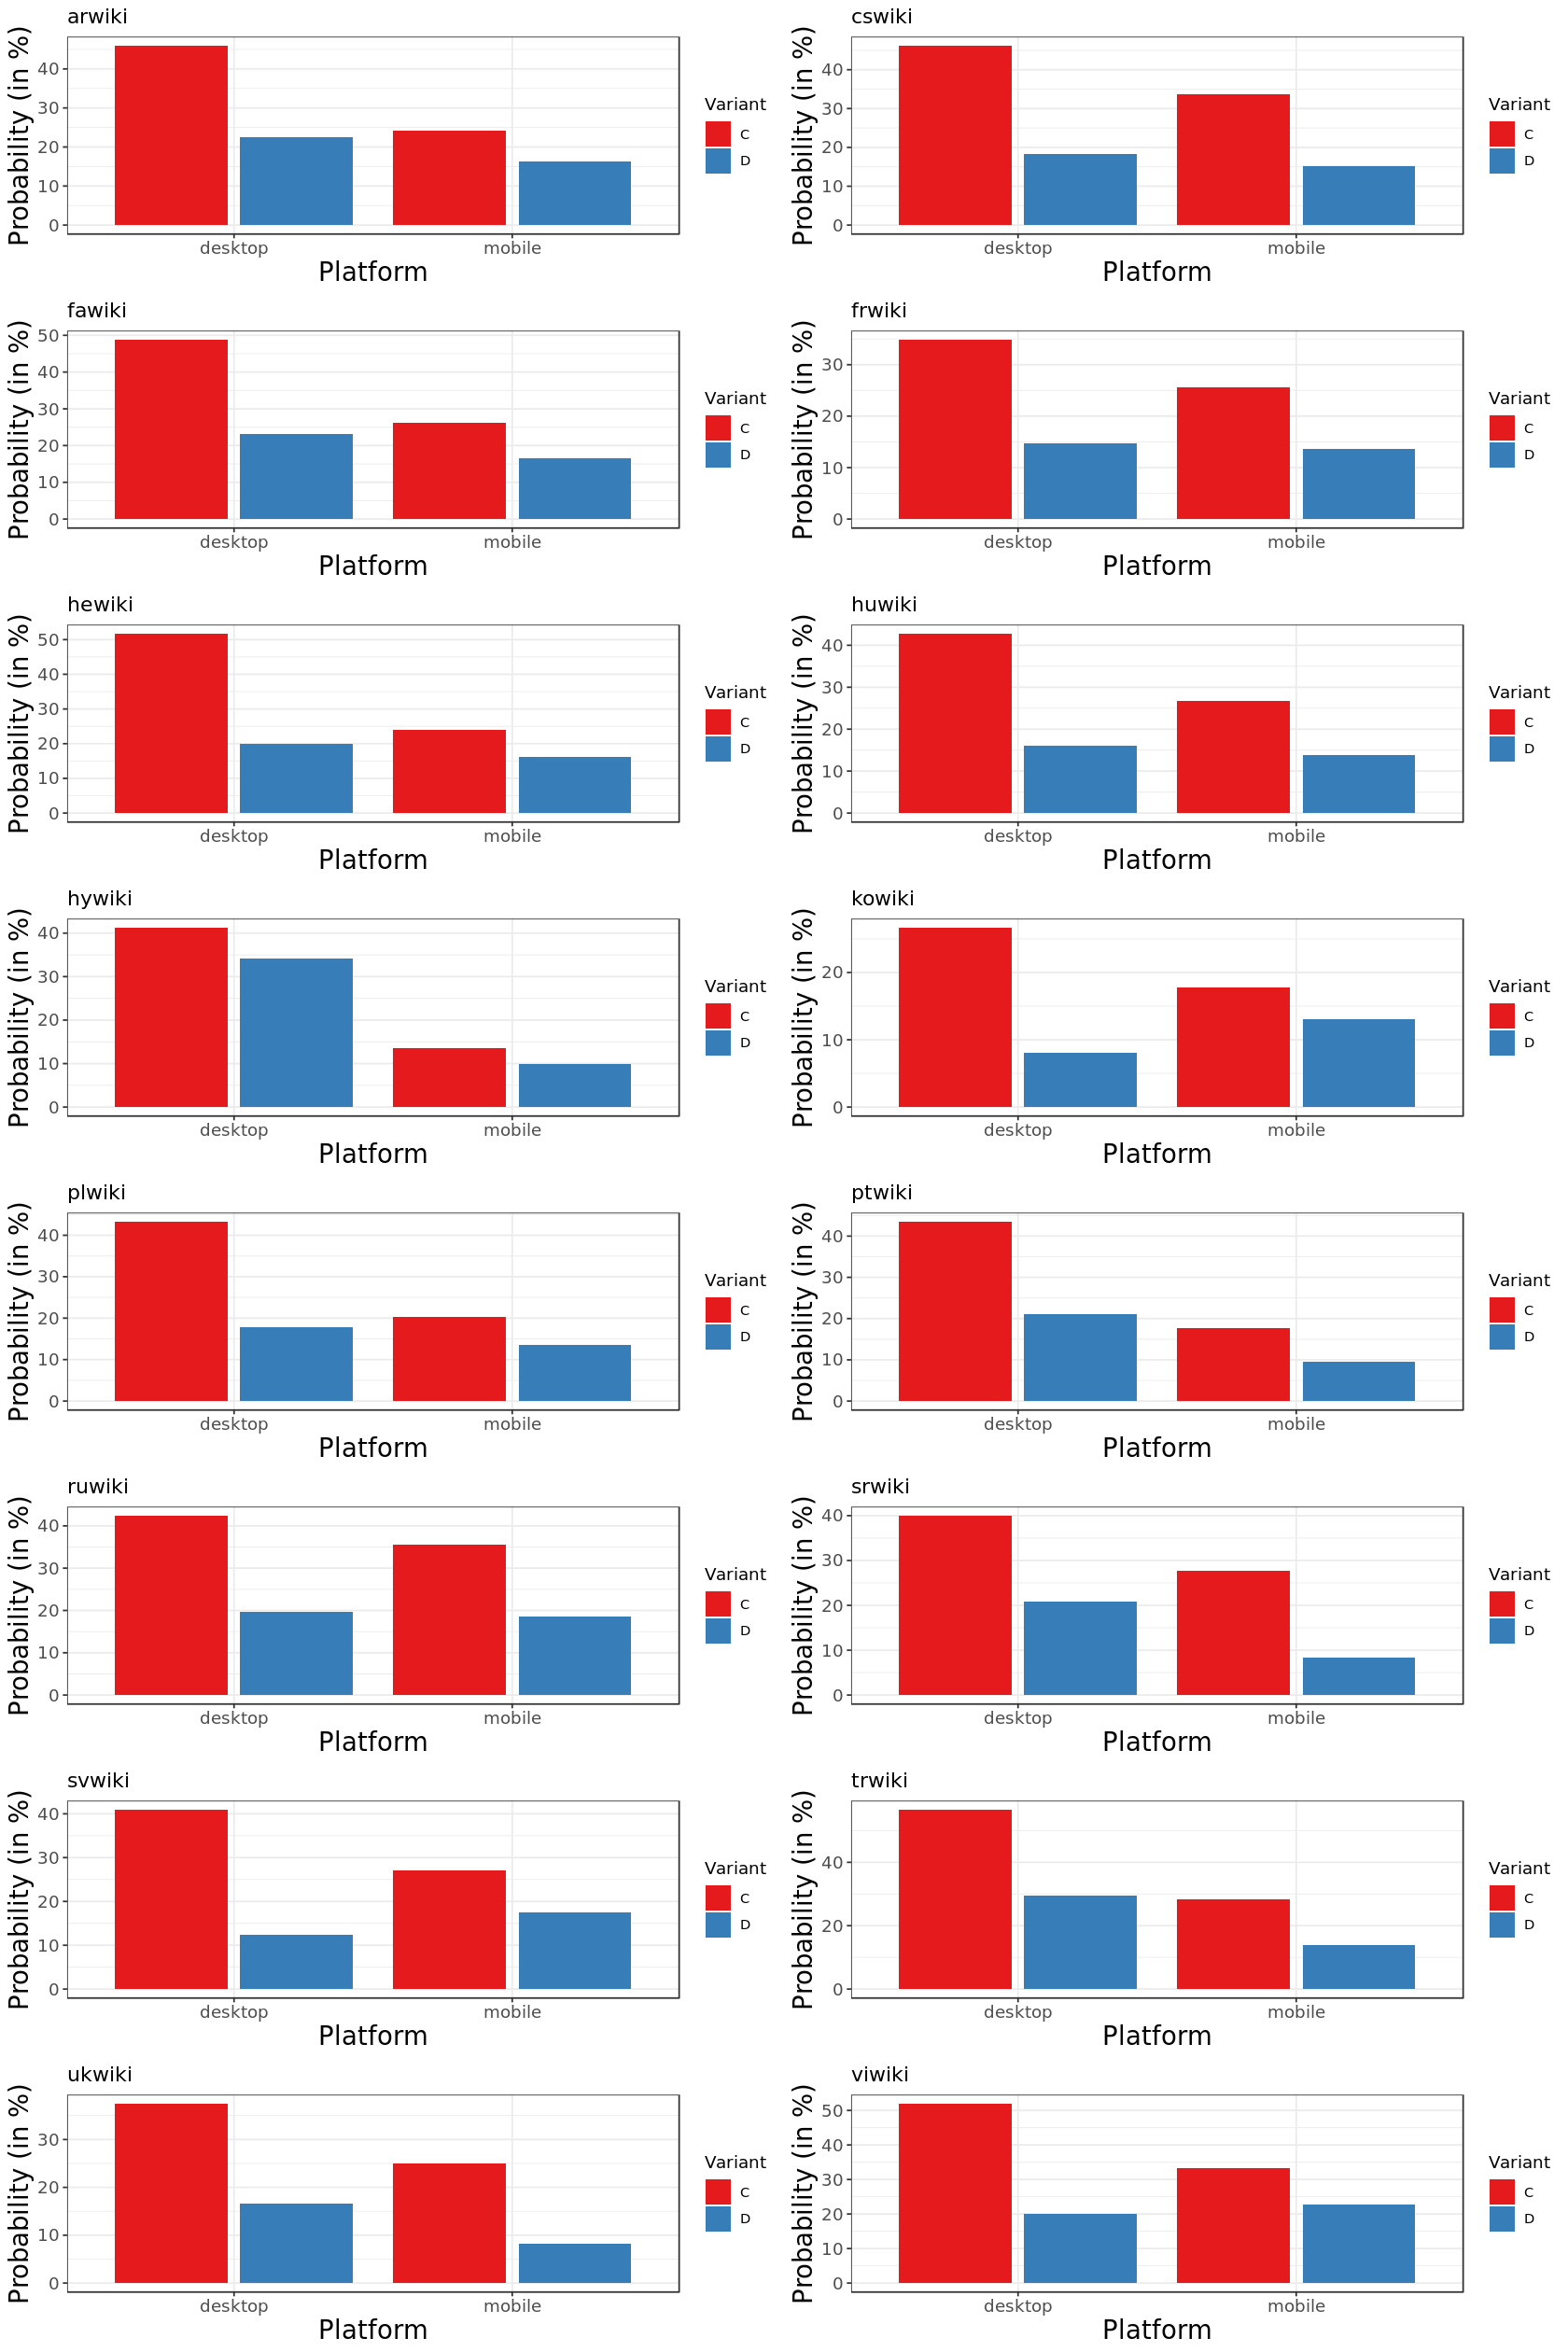

In [41]:
options(repr.plot.width = 14, repr.plot.height = 21)
grid.arrange(grobs = plots, ncol = 2)

One thing to note about these graphs is that Variant D is lower than Variant C across all wikis and platforms. For task navigation, task clicks, and saving a suggested edit, we had various wikis and platforms where Variant D is higher.

## Summary


## Additional analysis

What's the probability difference of navigating and clicking across the dataset for C vs D?

In [55]:
merged_interaction_counts[, list(n_visitors = sum(n_visitors), n_interacted = sum(n_interacted),
                      perc_interacted = 100 * sum(n_interacted) / sum(n_visitors)),
                          by = c('platform', 'hp_variant')]

platform,hp_variant,n_visitors,n_interacted,perc_interacted
<fct>,<fct>,<int>,<int>,<dbl>
desktop,C,9567,4081,42.65705
desktop,D,9379,1809,19.28777
mobile,C,6798,1714,25.21330
mobile,D,6871,1008,14.67035
